In [ ]:
#import necessary library for plotting images, training and ease in downloading and pre-processing and pre-trained models on the ImageNet dataset for image classification tasks
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_datasets as tfds

from tensorflow.keras.applications.resnet import ResNet50,ResNet101, preprocess_input
from tensorflow.keras.applications.vgg16 import VGG16,preprocess_input

In [ ]:
#get tensorflow dataset 'eurosat' and get INFO such as  dataset name, version, description, citation, features (e.g., image size, number of classes), and dataset size.

dataset = tfds.builder('eurosat')
info = dataset.info
print(info)

tfds.core.DatasetInfo(
    name='eurosat',
    full_name='eurosat/rgb/2.0.0',
    description="""
    EuroSAT dataset is based on Sentinel-2 satellite images covering 13 spectral
    bands and consisting of 10 classes with 27000 labeled and
    geo-referenced samples.
    
    Two datasets are offered:
    - rgb: Contains only the optical R, G, B frequency bands encoded as JPEG image.
    - all: Contains all 13 bands in the original value range (float32).
    
    URL: https://github.com/phelber/eurosat
    """,
    config_description="""
    Sentinel-2 RGB channels
    """,
    homepage='https://github.com/phelber/eurosat',
    data_dir=PosixGPath('/tmp/tmpgrnsdgn1tfds'),
    file_format=tfrecord,
    download_size=89.91 MiB,
    dataset_size=Unknown size,
    features=FeaturesDict({
        'filename': Text(shape=(), dtype=string),
        'image': Image(shape=(64, 64, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=10),
    }),
    supervised_keys=('

In [ ]:
# Attribute provides information about the features included in the dataset.
info.features

FeaturesDict({
    'filename': Text(shape=(), dtype=string),
    'image': Image(shape=(64, 64, 3), dtype=uint8),
    'label': ClassLabel(shape=(), dtype=int64, num_classes=10),
})

In [ ]:
#Generates a list of class names corresponding to the integer labels in the Eurosat dataset
class_names = []
for i in range(info.features["label"].num_classes):
  class_names.append(info.features["label"].int2str(i))

class_names

['AnnualCrop',
 'Forest',
 'HerbaceousVegetation',
 'Highway',
 'Industrial',
 'Pasture',
 'PermanentCrop',
 'Residential',
 'River',
 'SeaLake']

In [ ]:
#get a list containing the keys representing the available data splits in the Eurosat dataset.
list(info.splits.keys())

['train']

In [ ]:
# The resulting split datasets are assigned to variables train, val, and test, respectively, using tuple unpacking.
(train, val, test) = tfds.load("eurosat/rgb", split=["train[:80%]", "train[80%:90%]", "train[90%:]"])

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

In [ ]:
# Used to retrieve the next data point from the train dataset.
datapoint = next(iter(train))
datapoint

{'filename': <tf.Tensor: shape=(), dtype=string, numpy=b'Forest_687.jpg'>,
 'image': <tf.Tensor: shape=(64, 64, 3), dtype=uint8, numpy=
 array([[[35, 59, 71],
         [35, 59, 71],
         [36, 60, 72],
         ...,
         [32, 60, 72],
         [31, 59, 70],
         [33, 63, 73]],
 
        [[35, 59, 71],
         [34, 61, 72],
         [37, 61, 73],
         ...,
         [31, 59, 70],
         [31, 59, 70],
         [33, 63, 73]],
 
        [[37, 64, 73],
         [35, 64, 72],
         [38, 65, 74],
         ...,
         [35, 63, 74],
         [31, 59, 70],
         [32, 61, 69]],
 
        ...,
 
        [[31, 54, 70],
         [29, 55, 68],
         [32, 59, 70],
         ...,
         [33, 62, 70],
         [32, 60, 71],
         [34, 62, 73]],
 
        [[33, 59, 72],
         [32, 59, 70],
         [32, 59, 70],
         ...,
         [32, 60, 71],
         [37, 66, 74],
         [35, 65, 73]],
 
        [[34, 62, 73],
         [33, 61, 72],
         [35, 62, 73],
     

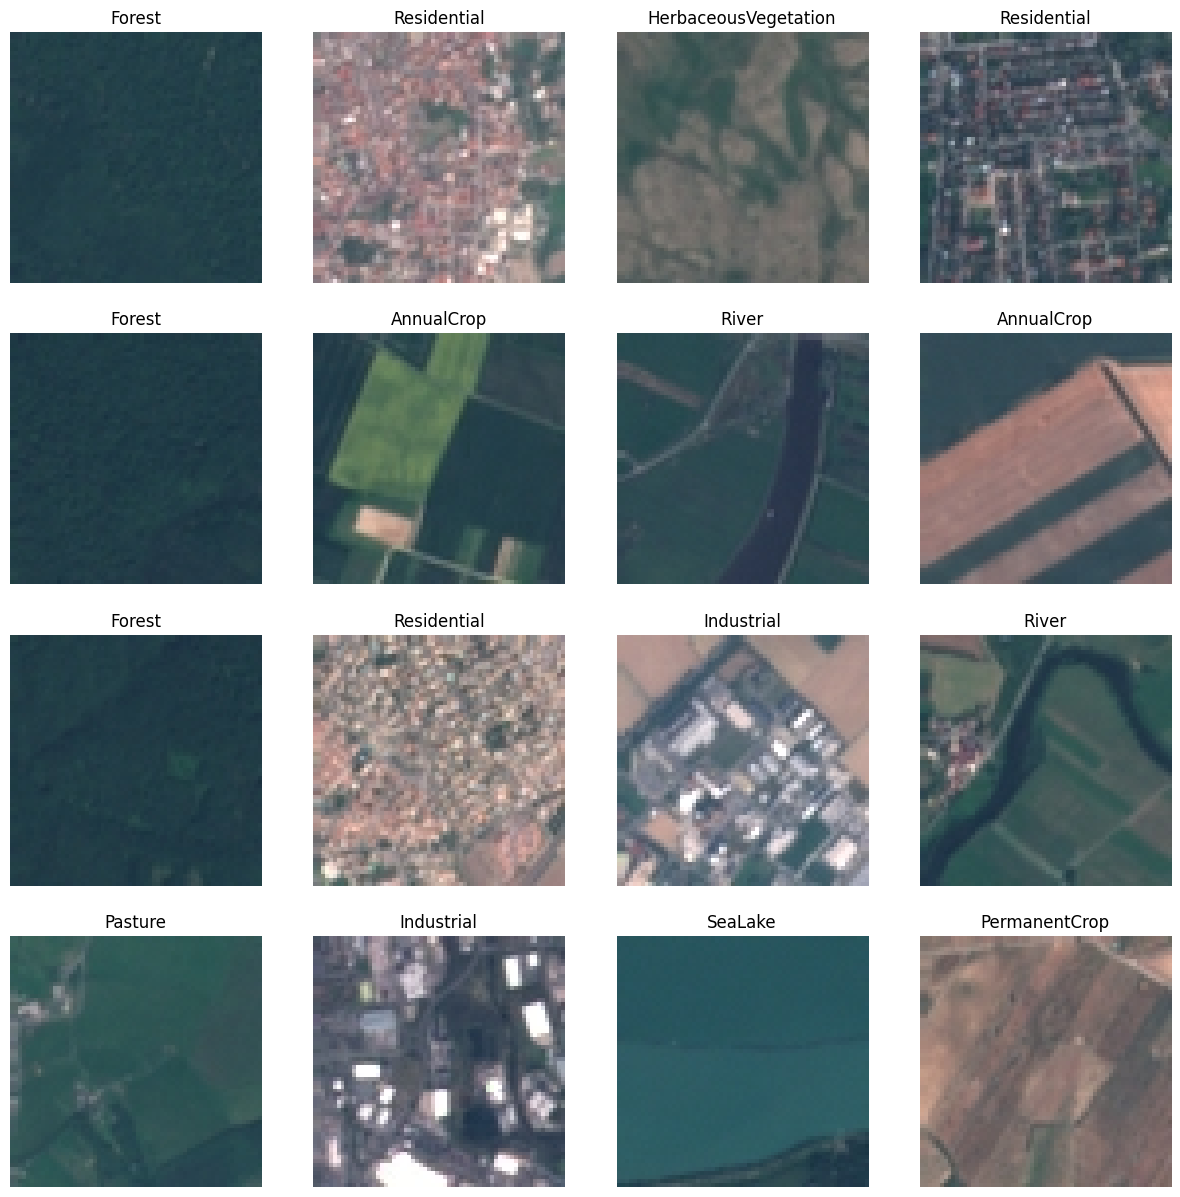

In [ ]:
#plot
plt.figure(figsize=(15, 15))
for i, datapoint in enumerate(tfds.as_numpy(train.take(16))):
  ax = plt.subplot(4, 4, i+1)
  plt.imshow(datapoint["image"])
  plt.title(class_names[datapoint["label"]])
  plt.axis("off")
plt.show()

In [ ]:
NUM_EPOCHS = 1
BATCH_SIZE = 64
BUFFER_SIZE = 1000

IMAGE_SHAPE = [128, 125]
NUM_CLASSES = info.features["label"].num_classes

In [ ]:
#data augmentation
tf.random.uniform(())  # This will generate a random floating number from 0-1

<tf.Tensor: shape=(), dtype=float32, numpy=0.6521028>

In [ ]:
@tf.function #compiles the decorated function into a TensorFlow graph
def prepare_training_data(datapoint):
  input_image = tf.image.resize(datapoint["image"], IMAGE_SHAPE)

  if tf.random.uniform(()) > 0.5:
    input_image = tf.image.random_flip_left_right(input_image)
    input_image = tf.image.random_flip_up_down(input_image)
    input_image = tf.image.random_brightness(input_image, max_delta=0.3)
    input_image = tf.image.random_saturation(input_image, lower=0.75, upper=1.5)
    input_image = tf.image.random_contrast(input_image, lower=0.75, upper=1.5)

  input_image = preprocess_input(input_image)

  return input_image, datapoint["label"]

def prepare_validation_data(datapoint):
  input_image = tf.image.resize(datapoint["image"], IMAGE_SHAPE)
  input_image = preprocess_input(input_image)

  return input_image, datapoint["label"]

In [ ]:
train = train.map(prepare_training_data, num_parallel_calls=tf.data.experimental.AUTOTUNE)
validation = val.map(prepare_validation_data)

train_dataset = train.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
validation_dataset = validation.batch(BATCH_SIZE)

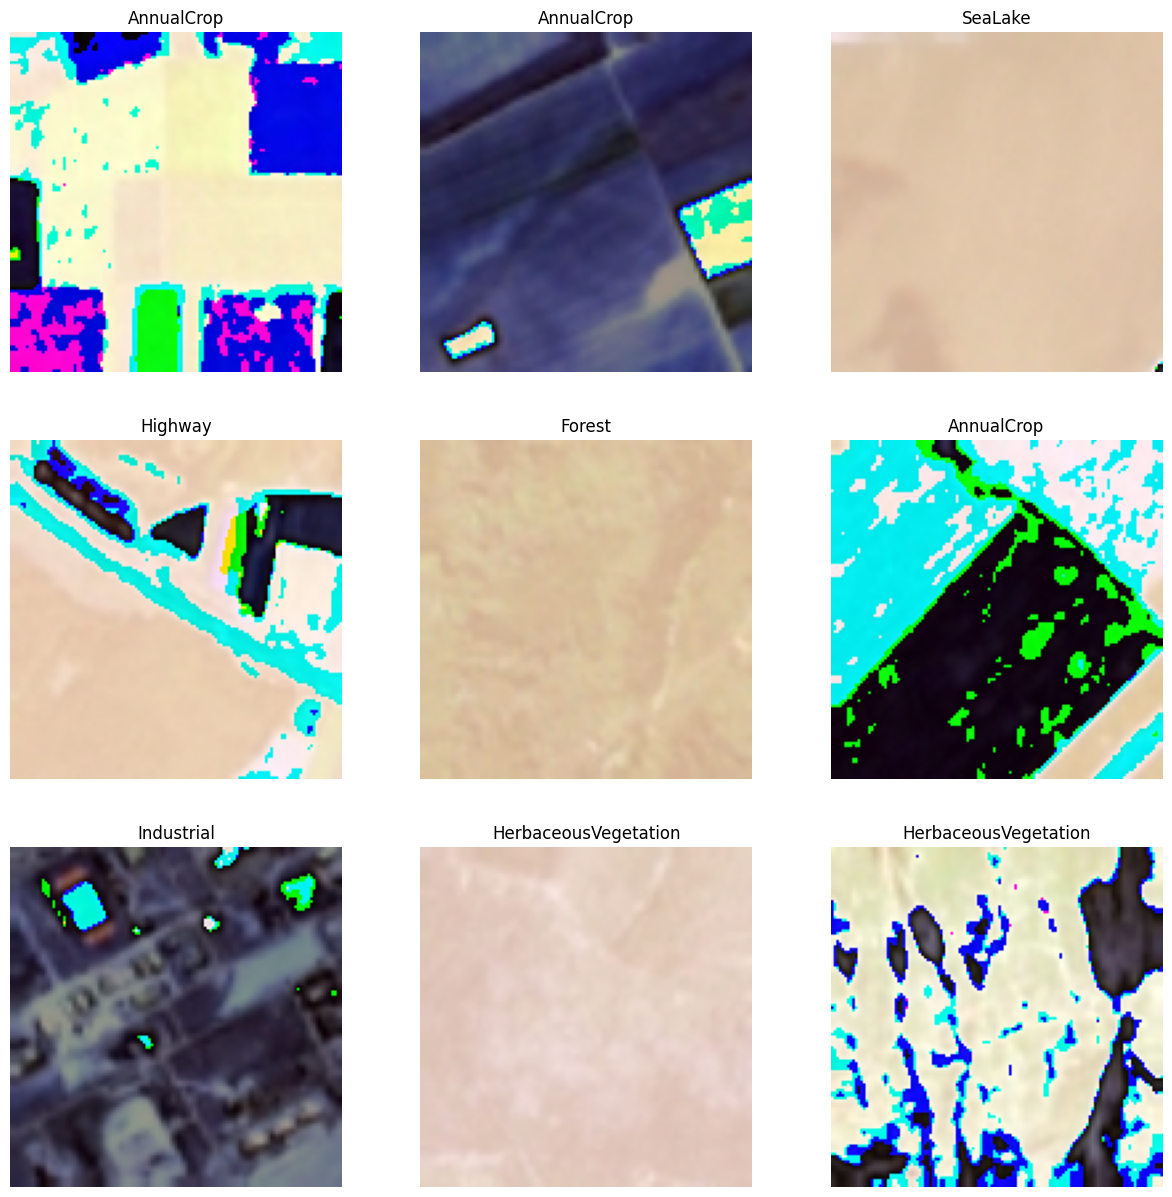

In [ ]:
#visualize preprocess image
plt.figure(figsize=(15, 15))
for i in range(9):
  ax = plt.subplot(3, 3, i+1)
  for datapoint in tfds.as_numpy(train_dataset.take(1)):
    plt.imshow(datapoint[0][0].astype('uint8'))
    plt.title(class_names[datapoint[1][0]])
    plt.axis("off")

plt.show()

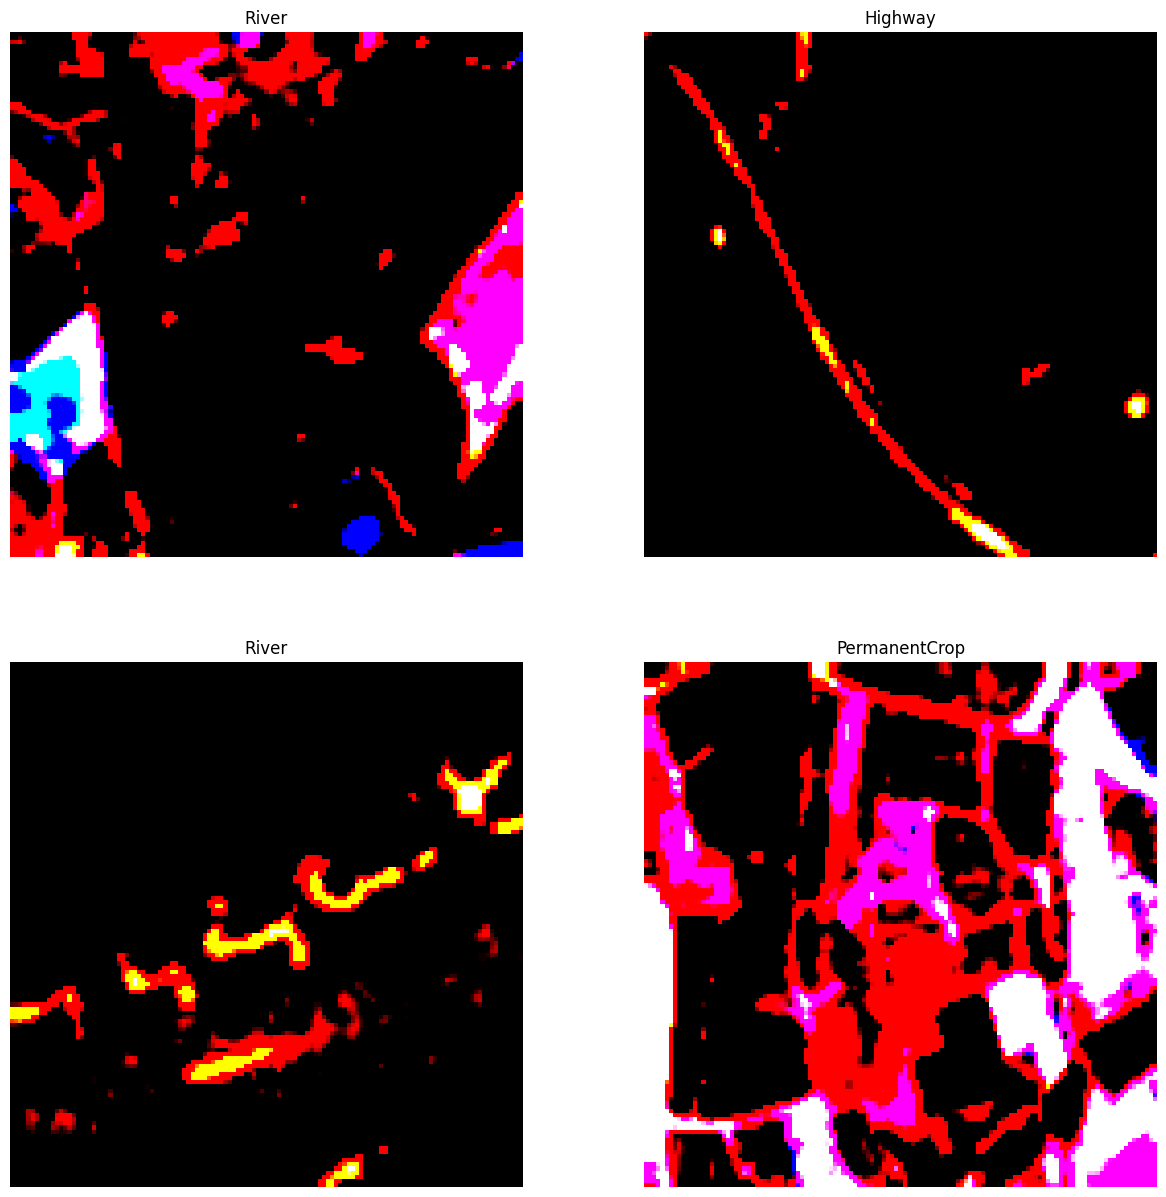

In [ ]:
#without using uint8
plt.figure(figsize=(15, 15))
for i in range(4):
  ax = plt.subplot(2, 2, i+1)
  for datapoint in tfds.as_numpy(train_dataset.take(1)):
    plt.imshow(datapoint[0][0])
    plt.title(class_names[datapoint[1][0]])
    plt.axis("off")

plt.show()

In [ ]:
#model

vgg = VGG16(input_shape=IMAGE_SHAPE+[3], weights='imagenet', include_top=False)

for layer in vgg.layers:
  layer.trainable = False

x = tf.keras.layers.GlobalAveragePooling2D()(vgg.output)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(512, activation='relu')(x)
predicition = tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')(x)

model = tf.keras.models.Model(inputs=vgg.input, outputs=predicition)

58889256/58889256 [==============================] - 0s 0us/step


In [ ]:
model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    optimizer='adam',
    metrics=['accuracy']
)

In [ ]:
STEPS_PER_EPOCH = int(info.splits["train"].num_examples * 0.8)//BATCH_SIZE
VALIDATION_STEPS = int(info.splits["train"].num_examples * 0.1)//BATCH_SIZE

In [ ]:

# Defining the parameters grid for GridSearchCV
param_grid={'C':[0.1,1,10,100],
            'gamma':[0.0001,0.001,0.1,1],
            'kernel':['rbf','poly']}

# Creating a support vector classifier
svc=svm.SVC(probability=True)

# Creating a model using GridSearchCV with the parameters grid
model=GridSearchCV(svc,param_grid)

# Training the model using the training data
model.fit(train_dataset)

# Testing the model using the testing data
y_pred = model.predict(validation_dataset)

# Calculating the accuracy of the model
accuracy = accuracy_score(train_dataset,validation_dataset)

# Print the accuracy of the model
print(f"The model is {accuracy*100}% accurate")

337/337 [==============================] - 4018s 12s/step - loss: 0.0908 - accuracy: 0.9702 - val_loss: 0.3027 - val_accuracy: 0.9167


In [ ]:
model.save('model.h5')

<Axes: >

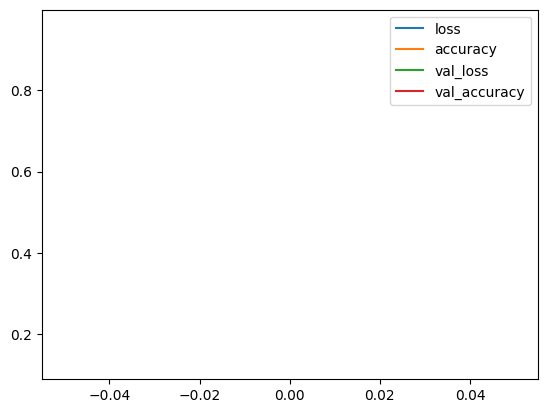

In [ ]:
import pandas as pd

pd.DataFrame(history.history).plot()

In [ ]:
#evaluate

test_dataset = test.map(prepare_validation_data)
test_dataset = test_dataset.batch(BATCH_SIZE)

In [ ]:
model.evaluate(test_dataset)

43/43 [==============================] - 449s 10s/step - loss: 0.2306 - accuracy: 0.9344


[0.23057666420936584, 0.9344444274902344]

1/1 [==============================] - 0s 172ms/step


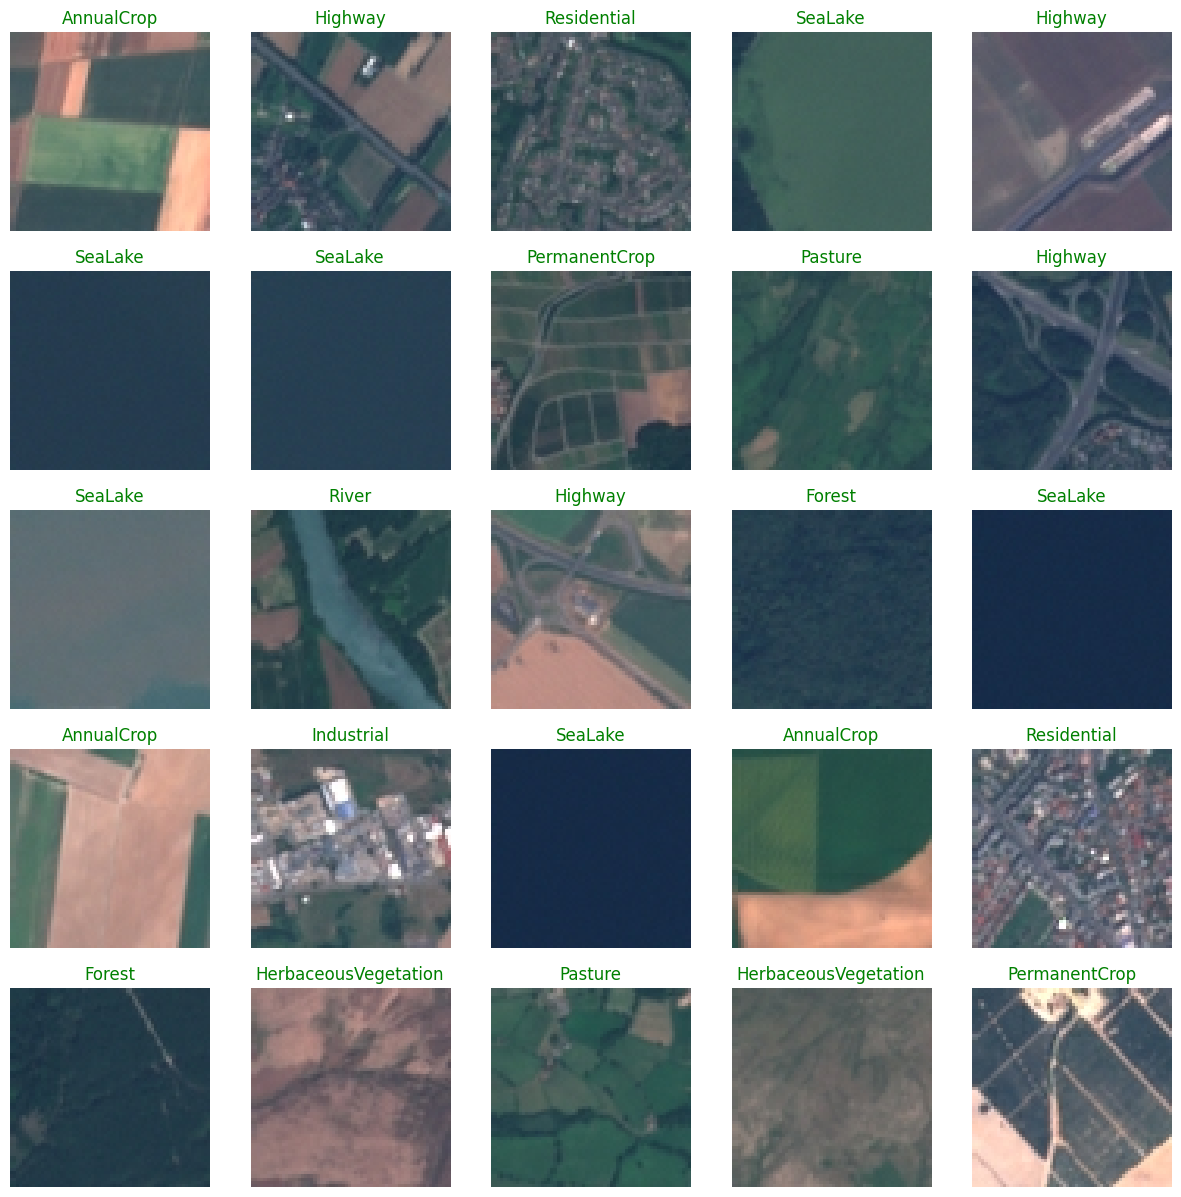

In [ ]:
plt.figure(figsize=(15, 15))
for i, datapoint in enumerate(tfds.as_numpy(test.take(25))):
  ax = plt.subplot(5, 5, i+1)
  plt.imshow(datapoint["image"])
  image = tf.image.resize(datapoint["image"], IMAGE_SHAPE)
  image = preprocess_input(image)
  image = np.expand_dims(image, axis=0)

  if datapoint["label"] == np.argmax(model.predict(image)):
    plt.title(class_names[np.argmax(model.predict(image))], color="green")
  else:
    plt.title(class_names[np.argmax(model.predict(image))], color="red")

  plt.axis("off")

plt.show()